In [36]:
!pip install sentencepiece

In [37]:
import pandas as pd
import numpy as np
import re

In [38]:
train_data = pd.read_csv('ChatbotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [39]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [40]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [6]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [7]:
import sentencepiece as spm

In [8]:
with open('all.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(questions))
    f.write('\n'.join(answers))

In [9]:
corpus = "all.txt"
prefix = "chatbot"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=all.txt --model_prefix=chatbot --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: all.txt
  input_format: 
  model_prefix: chatbot
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  user_defined_sym

In [10]:
vocab_file = "chatbot.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [11]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

START_TOKEN = [2]
END_TOKEN = [3]

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    zeros1 = np.zeros(MAX_LENGTH, dtype=int)
    zeros2 = np.zeros(MAX_LENGTH, dtype=int)
    sentence1 = START_TOKEN + vocab.encode_as_ids(sentence1) + END_TOKEN
    zeros1[:len(sentence1)] = sentence1[:MAX_LENGTH]

    sentence2 = START_TOKEN + vocab.encode_as_ids(sentence2) + END_TOKEN
    zeros2[:len(sentence2)] = sentence2[:MAX_LENGTH]

    tokenized_inputs.append(zeros1)
    tokenized_outputs.append(zeros2)
  return tokenized_inputs, tokenized_outputs

In [12]:
questions_encode, answers_encode = tokenize_and_filter(questions, answers)

In [13]:
print(questions_encode[0])
print(answers_encode[0])

[   2 5567 6968 3211  111    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[   2 5194  217 5936    7    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [14]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(ninp, nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder = nn.Embedding(ntoken, ninp)

        self.pos_encoder_d = PositionalEncoding(ninp, dropout)
        self.encoder_d = nn.Embedding(ntoken, ninp)

        self.ninp = ninp
        self.ntoken = ntoken

        self.linear = nn.Linear(ninp, ntoken)
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, tgt, srcmask, tgtmask, srcpadmask, tgtpadmask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt) * math.sqrt(self.ninp)
        tgt = self.pos_encoder_d(tgt)


        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask, src_key_padding_mask=srcpadmask, tgt_key_padding_mask=tgtpadmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [15]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, questions, answers):
        questions = np.array(questions)
        answers = np.array(answers)
        self.inputs = questions
        self.dec_inputs = answers[:,:-1]
        self.outputs = answers[:,1:]
        self.length = len(questions)
    
    def __getitem__(self,idx):
        return (self.inputs[idx], self.dec_inputs[idx], self.outputs[idx])

    def __len__(self):
        return self.length

BATCH_SIZE = 64
dataset = SequenceDataset(questions_encode, answers_encode)
dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [16]:
device = torch.device("cuda")

lr = 1e-4
model = TFModel(vocab_size+7, 256, 8, 512, 2, 0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


vocab size = vocab size + 7(tokens)  
lr = 1e-4  
d_emb model = 256  
num heads = 8  
dff = 512  
num_layer = 2  
dropout = 0.1  
BATCH_SIZE = 64

In [17]:
epoch = 30
from tqdm import tqdm

model.train()
for i in range(epoch):
    batchloss = 0.0
    progress = tqdm(dataloader)
    for (inputs, dec_inputs, outputs) in progress:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(MAX_LENGTH).to(device)
        src_padding_mask = gen_attention_mask(inputs).to(device)
        tgt_mask = model.generate_square_subsequent_mask(MAX_LENGTH-1).to(device)
        tgt_padding_mask = gen_attention_mask(dec_inputs).to(device)

        result = model(inputs.to(device), dec_inputs.to(device), src_mask, tgt_mask, src_padding_mask,tgt_padding_mask)
        loss = criterion(result.permute(1,2,0), outputs.to(device).long())
        progress.set_description("{:0.3f}".format(loss))
        loss.backward()
        optimizer.step()
        batchloss += loss
    print("epoch:",i+1,"|","loss:",batchloss.cpu().item() / len(dataloader))

  0%|          | 0/185 [00:00<?, ?it/s]/opt/conda/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
1.200: 100%|██████████| 185/185 [00:08<00:00, 20.56it/s]


epoch: 1 | loss: 1.7367147909628378


0.948: 100%|██████████| 185/185 [00:08<00:00, 21.03it/s]


epoch: 2 | loss: 1.0689259297138936


0.929: 100%|██████████| 185/185 [00:08<00:00, 20.78it/s]


epoch: 3 | loss: 1.0205562282252956


1.003: 100%|██████████| 185/185 [00:08<00:00, 20.82it/s]


epoch: 4 | loss: 0.9933618493982264


0.960: 100%|██████████| 185/185 [00:08<00:00, 21.09it/s]


epoch: 5 | loss: 0.9707379315350507


1.096: 100%|██████████| 185/185 [00:08<00:00, 21.28it/s]


epoch: 6 | loss: 0.9515060837204392


0.938: 100%|██████████| 185/185 [00:08<00:00, 21.38it/s]


epoch: 7 | loss: 0.9328920931429476


0.919: 100%|██████████| 185/185 [00:08<00:00, 21.44it/s]


epoch: 8 | loss: 0.9126381539009712


0.850: 100%|██████████| 185/185 [00:08<00:00, 21.38it/s]


epoch: 9 | loss: 0.8923018171980575


0.828: 100%|██████████| 185/185 [00:08<00:00, 21.30it/s]


epoch: 10 | loss: 0.8717954068570524


0.769: 100%|██████████| 185/185 [00:08<00:00, 21.17it/s]


epoch: 11 | loss: 0.8507085851720861


0.814: 100%|██████████| 185/185 [00:08<00:00, 21.11it/s]


epoch: 12 | loss: 0.8297703098606419


0.824: 100%|██████████| 185/185 [00:08<00:00, 21.08it/s]


epoch: 13 | loss: 0.8083848283097551


0.844: 100%|██████████| 185/185 [00:08<00:00, 21.08it/s]


epoch: 14 | loss: 0.7873042751002957


0.739: 100%|██████████| 185/185 [00:08<00:00, 21.18it/s]


epoch: 15 | loss: 0.7656348151129645


0.700: 100%|██████████| 185/185 [00:08<00:00, 21.18it/s]


epoch: 16 | loss: 0.7435122103304477


0.687: 100%|██████████| 185/185 [00:08<00:00, 21.19it/s]


epoch: 17 | loss: 0.7216505720808699


0.648: 100%|██████████| 185/185 [00:08<00:00, 21.22it/s]


epoch: 18 | loss: 0.7001219053526182


0.665: 100%|██████████| 185/185 [00:08<00:00, 21.19it/s]


epoch: 19 | loss: 0.6776258726377745


0.654: 100%|██████████| 185/185 [00:08<00:00, 21.16it/s]


epoch: 20 | loss: 0.6546461363096495


0.634: 100%|██████████| 185/185 [00:08<00:00, 21.21it/s]


epoch: 21 | loss: 0.6317866557353252


0.559: 100%|██████████| 185/185 [00:08<00:00, 21.20it/s]


epoch: 22 | loss: 0.6084829794394003


0.595: 100%|██████████| 185/185 [00:08<00:00, 21.19it/s]


epoch: 23 | loss: 0.5852791863518793


0.472: 100%|██████████| 185/185 [00:08<00:00, 21.16it/s]


epoch: 24 | loss: 0.562544786607897


0.633: 100%|██████████| 185/185 [00:08<00:00, 21.16it/s]


epoch: 25 | loss: 0.5408105798669763


0.563: 100%|██████████| 185/185 [00:08<00:00, 21.17it/s]


epoch: 26 | loss: 0.5184783523147171


0.513: 100%|██████████| 185/185 [00:08<00:00, 21.11it/s]


epoch: 27 | loss: 0.49597704088365707


0.409: 100%|██████████| 185/185 [00:08<00:00, 21.14it/s]


epoch: 28 | loss: 0.4735247225374789


0.461: 100%|██████████| 185/185 [00:08<00:00, 21.16it/s]


epoch: 29 | loss: 0.4525422379777238


0.439: 100%|██████████| 185/185 [00:08<00:00, 21.17it/s]


epoch: 30 | loss: 0.43134448077227616


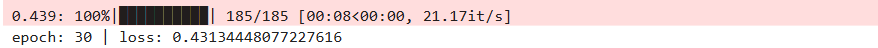

In [18]:
torch.save(model.state_dict(), "chatbot.pth")

In [19]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    input = torch.tensor([START_TOKEN + vocab.encode_as_ids(sentence) + END_TOKEN]).to(device)
    output = torch.tensor([START_TOKEN]).to(device)

    # 디코더의 예측 시작
    model.eval()
    for i in range(MAX_LENGTH):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        src_padding_mask = gen_attention_mask(input).to(device)
        tgt_padding_mask = gen_attention_mask(output).to(device)

        predictions = model(input, output, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask).transpose(0,1)
        # 현재(마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = torch.LongTensor(torch.argmax(predictions.cpu(), axis=-1))


        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if torch.equal(predicted_id[0][0], torch.tensor(END_TOKEN[0])):
            break

        # 마지막 시점의 예측 단어를 출력에 연결한다.
        # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = torch.cat([output, predicted_id.to(device)], axis=1)

    return torch.squeeze(output, axis=0).cpu().numpy()

def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = vocab.Decode(list(map(int,[i for i in prediction if i < vocab_size+7])))

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [20]:
model.load_state_dict(torch.load("chatbot.pth"))
result = predict("난 뭘 해야 할까?")

Input: 난 뭘 해야 할까?
Output: 좋아하는 건 없어요 .


증강X, 전처리는 기본으로 한 베이스라인 모델을 구현했다. loss값은 잘 내려갔지만 결과값이 만족스럽지 못하다. 이제 과적합을 방지하기 위해 데이터 증강, validation set 분리, 하이퍼 파라미터 튜닝을 진행하겠다.

In [21]:
!pip install gensim==4.3.3


In [22]:
from gensim.models import KeyedVectors

# Word2Vec bin 파일 경로
bin_file_path = "ko_c.bin"

wv = KeyedVectors.load_word2vec_format(bin_file_path, binary=True)


In [23]:
# Q. Lexical Substitution 을 구현해봅시다.
def lexical_sub(sentence, wv):
    # 문장을 토큰화
    tokens = sentence.split()

    # 유효한 단어 필터링 (임베딩에 존재하는 단어만 고려)
    valid_tokens = [tok for tok in tokens if tok in wv]

    # 대체할 단어 선택 (임베딩 내 존재하는 단어 중 하나)
    if not valid_tokens:
        return sentence  # 모든 단어가 임베딩 내에 없으면 원래 문장 반환

    selected_tok = random.choice(valid_tokens)

    # 가장 유사한 단어 찾기
    similar_word = wv.most_similar(selected_tok)[0][0]

    # 변환된 문장 생성
    new_sentence = " ".join([similar_word if tok == selected_tok else tok for tok in tokens])

    return new_sentence

In [24]:
from tqdm import tqdm
import random

new_corpus = []

for old_src in tqdm(questions):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None:
        new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src)

print(new_corpus[:10])

100%|██████████| 11823/11823 [00:19<00:00, 607.82it/s]

['12시 끗 !', '12시 땡 !', '1지망 학교의 떨어졌어', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 놀러가고 싶다', '3박4일 만큼 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'PPL 심하네']


In [25]:
import random
new_corpus = []

for old_src in tqdm(answers):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None:
        new_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src)

print(new_corpus[:10])

100%|██████████| 11823/11823 [00:25<00:00, 466.27it/s]

['하루가 각기 가네요 .', '하루가 또 가네요 .', '위로해 드립니다 는데', '위로해 드립니다 .', '여행은 항상 좋죠 .', '여행은 언제나 좋죠 .', '여행은 항상 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 는데', '눈살이 찌푸려지죠 .']


일반적으로 쓰이지 않는 문장들이지만, 형태적으로는 몰라도 의미적으로는 옳은 문장이므로 그대로 진행한다..

In [26]:
device = torch.device("cuda")

lr = 1e-4
model = TFModel(vocab_size+7, 256, 8, 512, 2, 0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
epoch = 30

model.train()
for i in range(epoch):
    batchloss = 0.0
    progress = tqdm(dataloader)
    for (inputs, dec_inputs, outputs) in progress:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(MAX_LENGTH).to(device)
        src_padding_mask = gen_attention_mask(inputs).to(device)
        tgt_mask = model.generate_square_subsequent_mask(MAX_LENGTH-1).to(device)
        tgt_padding_mask = gen_attention_mask(dec_inputs).to(device)

        result = model(inputs.to(device), dec_inputs.to(device), src_mask, tgt_mask, src_padding_mask,tgt_padding_mask)
        loss = criterion(result.permute(1,2,0), outputs.to(device).long())
        progress.set_description("{:0.3f}".format(loss))
        loss.backward()
        optimizer.step()
        batchloss += loss
    print("epoch:",i+1,"|","loss:",batchloss.cpu().item() / len(dataloader))

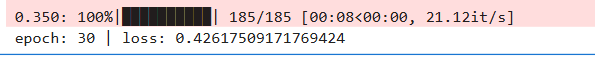

In [28]:
torch.save(model.state_dict(), "chatbot_withDataAug.pth")

In [30]:
model.load_state_dict(torch.load("chatbot.pth"))
result = predict("난 뭘 해야 할까?")

Input: 난 뭘 해야 할까?
Output: 좋아하는 건 없어요 .


과적합을 확인하기 위해 val set을 추가하여 그래프를 보고 과적합을 확인하겠다

In [31]:
from torch.utils.data import random_split, DataLoader

# 전체 데이터셋 (예: train_dataset)
total_size = len(dataset)
val_size = int(total_size * 0.2)   # 20%를 validation
train_size = total_size - val_size

dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader 생성
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [32]:
print(dataset[0])

(array([   2, 1752, 4994,    3,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0]), array([   2,  561, 3900,  936, 7026,  526,    7,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0]), array([ 561, 3900,  936, 7026,  526,    7,    3,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0]))


3개는 각각 inputseq, targetseq, decoderseq으로 볼 수 있다

이제 증강강도를 고정하고 다른 하이퍼 파라미터를 그리드 서치로 최적값을 찾아보겠다.

In [ ]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 하이퍼파라미터 후보 ===
param_grid = {
    "d_model": [256, 512],
    "num_heads": [4, 8],
    "dff": [512, 1024, 2048],
    "num_layers": [2, 4, 6],
    "dropout": [0.1, 0.2],
    "lr": [1e-3, 5e-4, 1e-4],
    "batch_size": [64, 128]
}

results = []

# === 마스크 생성 함수 ===
def create_masks(src, tgt, model):
    src_pad_mask = (src == 0)
    tgt_pad_mask = (tgt == 0)
    tgt_mask = model.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
    src_mask = None
    return src_mask, tgt_mask, src_pad_mask, tgt_pad_mask

# === Grid Search ===
for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    print(f"실행 중: {params}")

    train_loader = DataLoader(dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])

    model = TFModel(
        vocab_size + 7,
        params["d_model"],
        params["num_heads"],
        params["dff"],
        params["num_layers"],
        params["dropout"]
    ).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # === 학습 ===
    for epoch in range(10):#10개로 실시
        model.train()
        for input_seq, target_seq, decoder_input in train_loader:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            decoder_input = decoder_input.to(device)

            # 시퀀스 길이 맞추기 (batch 마지막에서 mismatch 방지)
            min_len = min(decoder_input.size(1), target_seq.size(1)-1)
            decoder_input = decoder_input[:, :min_len]
            target_seq_cut = target_seq[:, 1:][:, :min_len]

            src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_masks(input_seq, decoder_input, model)

            optimizer.zero_grad()
            outputs = model(
                input_seq,
                decoder_input,
                src_mask,
                tgt_mask,
                src_pad_mask,
                tgt_pad_mask
            )

            # outputs: (seq_len, batch, vocab) → (batch, seq_len, vocab)
            outputs = outputs.transpose(0,1)

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                target_seq_cut.reshape(-1)
            )
            loss.backward()
            optimizer.step()

    # === 검증 ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_seq, target_seq, decoder_input in val_loader:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            decoder_input = decoder_input.to(device)

            min_len = min(decoder_input.size(1), target_seq.size(1)-1)
            decoder_input = decoder_input[:, :min_len]
            target_seq_cut = target_seq[:, 1:][:, :min_len]

            src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_masks(input_seq, decoder_input, model)

            outputs = model(
                input_seq,
                decoder_input,
                src_mask,
                tgt_mask,
                src_pad_mask,
                tgt_pad_mask
            )
            outputs = outputs.transpose(0,1)

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                target_seq_cut.reshape(-1)
            )
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}")
    results.append((params, val_loss))

# === 최적 하이퍼파라미터 ===
best_params, best_loss = min(results, key=lambda x: x[1])
print("\n최적 하이퍼파라미터:", best_params)
print("Validation Loss:", best_loss)


실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64}


/opt/conda/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation Loss: 0.1421
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 128}
Validation Loss: 0.1395
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 64}
Validation Loss: 0.1463
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 128}
Validation Loss: 0.1664
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 64}
Validation Loss: 1.2101
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 128}
Validation Loss: 1.9573
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64}
Validation Loss: 0.1472
실행 중: {'d_model': 256, 'num_heads': 4, 'dff': 512, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128}
Validation Loss: 0.

맨 처음에 진행했을때에는     
    "d_model": [128, 256, 512],  
    "num_heads": [4, 8],  
    "dff": [512, 1024, 2048],  
    "num_layers": [2, 4, 6],  
    "dropout": [0.1, 0.2, 0.3],  
    "lr": [1e-3, 5e-4, 1e-4],  
    "batch_size": [32, 64, 128]  
으로 진행 하려 했으나, 머신 성능을 고려하지 않고 진행하여 1000여번의 계산을 하다가는 문제가 생길 거 같아 줄여서 진행하였다. 중간중간 버그가 많이 일어나 그 점을 아래에 정리해 두었다

1. ValueError: too many values to unpack (expected 2)
원인: DataLoader에서 튜플 (x, y, z) 형태의 데이터가 나오는데, 학습 루프에서 for x, y in train_loader:처럼 2개만 받으려 했기 때문.
해결: for input_seq, target_seq, decoder_input in train_loader:로 수정해서 3개를 받도록 변경.

2. TFModel.forward() missing 4 required positional arguments
원인: TFModel.forward()가 srcmask, tgtmask, srcpadmask, tgtpadmask를 반드시 받도록 정의되어 있음.
그런데 학습 루프에서 단순히 model(x, y)만 호출하여 마스크 인자를 전달하지 않았음.
해결: forward 호출 전에 마스크를 생성해서 함께 전달하도록 수정.
srcmask → 보통 None 사용
tgtmask → 미래 토큰 차단용 (causal mask)
srcpadmask, tgtpadmask → 패딩 토큰 무시용 마스크

3. ValueError: Expected input batch_size (1248) to match target batch_size (1216)
원인: outputs와 target의 시퀀스 길이가 다름.
outputs는 (seq_len, batch, vocab)
target은 [:, 1:]로 잘라 쓰는데 길이가 outputs와 안 맞을 수 있음 (특히 마지막 배치).
해결: 학습 루프에서 두 시퀀스 길이를 min_len = min(outputs_len, target_len)으로 맞춰 잘라냄.
decoder_input과 target_seq[:, 1:] 모두 min_len에 맞게 컷팅해서 loss 계산.

4. 출력 차원 문제
원인: PyTorch nn.Transformer 출력 차원은 (seq_len, batch, vocab)인데, CrossEntropyLoss는 (batch, seq_len, vocab)을 기대함.
해결: outputs = outputs.transpose(0,1)으로 차원을 맞춘 후 loss 계산.

5. 최종 정리된 학습 구조
데이터 로딩 → (input_seq, target_seq, decoder_input)
마스크 생성 (srcmask, tgtmask, srcpadmask, tgtpadmask)
모델 forward 호출 시 마스크 전달
출력 차원 변환 (seq_len, batch, vocab) → (batch, seq_len, vocab)
target 시퀀스와 길이 맞춤 후 loss 계산
역전파 및 최적화
즉, 오류들은 대부분
데이터 unpack 문제
forward() 인자 누락
출력/정답 시퀀스 길이 불일치
출력 차원 불일치
에서 발생했고, 각각 올바르게 인자 전달, 길이 맞춤, 차원 변환으로 해결되었습니다.

하지만 아직 추가 실험을 진행하고 싶다. 각 모델들에게 '공정한 기준' 을 적용한다면 lr이 작은 경우에는 더 많은 에포크를 돌려주어야 그 모델의 최대 퍼포먼스를 볼 수 있다고 생각한다.

In [ ]:
def calculate_bleu(hypotheses, list_of_references, max_n=4):

    assert len(hypotheses) == len(list_of_references)

    scores = []
    for hyp, refs in zip(hypotheses, list_of_references):
        score = bleu_score(hyp, refs, max_n=max_n)
        scores.append(score)

    corpus_bleu = sum(scores) / len(scores)
    return corpus_bleu, scores

In [ ]:
corpus_bleu, scores = calculate_bleu(hypotheses, list_of_references)
print("Corpus BLEU:", corpus_bleu)
print("Sentence BLEUs:", scores)